# Research Assistant Agent


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [53]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit, get_aclient  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from IPython.display import Image, Markdown, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

### Goal

- Build a lightweight, multi-agent system using chat models to customize the research process.

### Key Themes

- Integrates LangGraph themes like memory, human-in-the-loop, and controllability.

### Source Selection

- Allows users to choose input sources for their research.

### Planning

- Users provide a topic.
- The system generates a team of AI analysts, each focusing on a sub-topic.
- Human-in-the-loop will be used to refine sub-topics before research starts.

### LLM Utilization (Research Process)

- Each analyst conducts in-depth, multi-turn interviews with an expert AI based on selected sources, similar to the STORM paper.
- Interviews are captured in sub-graphs with internal state.
- Experts gather information in parallel and interviews are conducted simultaneously via map-reduce.

### Output Format

- Gathered insights from each interview are synthesized into a final report.
- Customizable prompts allow for flexible report output.

<br><hr>

### Create The LLM


In [61]:
from typing import Any, Type


from instructor.client import AsyncInstructor
from pydantic import BaseModel


class GeneralResponse(BaseModel):
    content: str


aclient: Any | AsyncInstructor = get_aclient(return_type="instructor")


async def allm_with_structured_output(
    client: AsyncInstructor,
    model: str,
    messages: dict[str, Any],
    response_model: Type[BaseModel],
) -> str:
    """Make an async call to LLM with structured output using instructor.

    Parameters
    ----------
    client : AsyncInstructor
        The async instructor client instance for making LLM calls
    model : str
        The model to use
    messages : dict[str, Any]
        The messages to send to the LLM
    response_model : Type[BaseModel]
        The Pydantic model class to structure the output

    Returns
    -------
    str
        The structured response from the LLM
    """
    return await client.chat.completions.create(
        response_model=response_model,
        model=model,
        messages=messages,
        max_retries=5,
        temperature=0.0,
        seed=2,
    )

In [ ]:
from langchain_core.language_models.chat_models import BaseChatModel

model_str: str = "mistralai:open-mixtral-8x22b"
llm: BaseChatModel = init_chat_model(
    model=model_str,
    temperature=0.0,
    seed=123,
)


# llm = init_chat_model(
llm = init_chat_model(
    model_provider="openai",
    openai_api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
    # model=ModelEnum.LLAMA_3p3_70B_INSTRUCT_REMOTE.value,
    model="qwen/qwen3-235b-a22b",
    temperature=0.0,
    seed=123,
)


aclient = get_aclient(return_type="instructor")


In [64]:
type(aclient)

instructor.client.AsyncInstructor

In [67]:
model: str = f"openrouter/{ModelEnum.QWEN_3p0_8B_REMOTE.value}"

response: GeneralResponse = await allm_with_structured_output(
    client=aclient,
    model=model,
    messages=[
        {"role": "user", "content": "Who be Tinubu?"},
    ],
    response_model=GeneralResponse,
)

console.log(response)

[20:37:32] GeneralResponse(                                                                        ]8;id=721158;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_42530/2105613715.py\2105613715.py]8;;\:]8;id=61035;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_42530/2105613715.py#12\12]8;;\
               content='Bola Tinubu is the 16th President of Nigeria, elected in 2023. He is a                     
           Nigerian politician and former business executive who previously served as the Governor                 
           of Lagos State from 2019 to 2023. Tinubu is known for his leadership in Lagos and his                   
           role in the 2023 presidential election, where he defeated former President Muhammadu                    
           Buhari.'                                                                                                
           )                                                                                                       

In [35]:
question = "Who be Tinubu?"

print(llm.invoke(question).content)

**Bola Ahmed Tinubu** (born March 29, 1952) is a Nigerian politician who has served as the **President of Nigeria** since May 29, 2023. He is a member of the **All Progressives Congress (APC)** party and is widely regarded as a key architect of the party's formation in 2013, which united several opposition groups to challenge the long-ruling People's Democratic Party (PDP).

### Key Background and Career:
1. **Early Life and Education**:  
   - Born in Lagos, Tinubu hails from a prominent Yoruba family. He studied in the U.S., earning a degree in Political Science from Chicago State University (1977) and a master's in Public Administration from Pepperdine University (1980).

2. **Political Career**:  
   - **Governor of Lagos State (1999–2007)**: His tenure is credited with modernizing Lagos' infrastructure, improving tax collection, and enhancing urban planning. However, critics argue his policies disproportionately affected lower-income communities.  
   - **APC Leadership**: He play

## Create Analysts: Human-in-the-loop

- Create analysts and review them using human-in-the-loop.

In [36]:
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str = Field(description="The primary affiliation of the analyst.")
    role: str = Field(description="The role of the analyst.")
    name: str = Field(description="The name of the analyst.")
    description: str = Field(
        description="The description of the analyst's focus, concerns and motives."
    )

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}"
            f"\nDescription: {self.description}"
        )


class Perpectives(BaseModel):
    analysts: list[Analyst] = Field(
        description="A list of analysts with their detailed information."
    )


class GenerateAnalystState(TypedDict):
    topic: str  # Research topic
    max_analyst: int  # Maximum number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: list[Analyst]  # Analyst asking questions

In [37]:
analyst_instructions: str = """
<instruction>
You're tasked with creating a set of AI analyst personas. Follow these instructions carefully:
1. First, review the reseacrch topic: \n{topic}
2. Examine any editorial feedback that has been optionally provided to guide the creation of the analysts:
{human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above.
4. Pick the top {max_analyst} themes.
5. Assign one analyst to each theme.
</instruction>
"""


async def create_analysts(state: GenerateAnalystState) -> dict[str, Any]:
    topic: str = state["topic"]
    max_analyst: int = state["max_analyst"]
    human_analyst_feedback: str = state.get("human_analyst_feedback", "")

    structured_llm = llm.with_structured_output(Perpectives)
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analyst=max_analyst,
    )
    analysts = await structured_llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {"analysts": analysts.analysts}


def human_feedback(state: GenerateAnalystState) -> None:
    pass


def should_continue(state: GenerateAnalystState) -> Literal["create_analysts", END]:
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

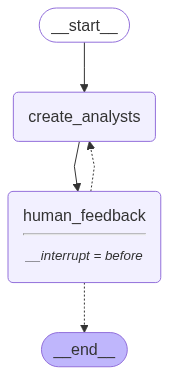

In [ ]:
from langgraph.graph.state import CompiledStateGraph


graph_builder = StateGraph(GenerateAnalystState)

# Add nodes
graph_builder.add_node("create_analysts", create_analysts)
graph_builder.add_node("human_feedback", human_feedback)

# Add edges
graph_builder.add_edge(START, "create_analysts")
graph_builder.add_edge("create_analysts", "human_feedback")
# Add conditions
graph_builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph: CompiledStateGraph = graph_builder.compile(
    interrupt_before=["human_feedback"], checkpointer=memory
)  # .with_config({"callbacks": [langfuse_handler]})

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

#### Test The Code

In [39]:
# Inputs
max_analyst: int = 3
topic: str = "The benefits of Christianity"
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(
    {"topic": topic, "max_analyst": max_analyst}, thread, stream_mode="values"
):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Eleanor Hart
Role: Senior Analyst
Affiliation: Institute for Faith and Wellbeing
Description: Specializes in the psychological and personal development benefits of Christian faith practices, focusing on mental health outcomes, community belonging, and ethical frameworks for decision-making. Combines theological scholarship with behavioral science methodologies.
--------------------------------------------------
Name: Professor Marcus Greene
Role: Lead Researcher
Affiliation: Global Social Impact Foundation
Description: Investigates Christianity's role in social justice movements, poverty alleviation through faith-based organizations, and the economic impact of Christian charitable networks. Uses quantitative data analysis and case studies from 20+ countries.
--------------------------------------------------
Name: Dr. Amina Khalid
Role: Historical Analyst
Affiliation: Center for Cultural Heritage Studies
Description: Examines Christianity's influence on art, education systems

In [40]:
# Get the state and look at the next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [41]:
# The next step is t update the state as if we're the human_feedback node
graph.update_state(
    thread,
    {"human_analyst_feedback": "Add a priest to add some apostolic and traditional perspective"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f043d15-b745-6e70-8002-7f01f38aa807'}}

In [42]:
# Continue the graph execution
input_: dict[str, Any] | None = None  # Continue the graph execution

# Run the graph
async for event in graph.astream(input_, thread, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Eleanor Hart
Role: Senior Analyst
Affiliation: Institute for Faith and Wellbeing
Description: Specializes in the psychological and personal development benefits of Christian faith practices, focusing on mental health outcomes, community belonging, and ethical frameworks for decision-making. Combines theological scholarship with behavioral science methodologies.
--------------------------------------------------
Name: Professor Marcus Greene
Role: Lead Researcher
Affiliation: Global Social Impact Foundation
Description: Investigates Christianity's role in social justice movements, poverty alleviation through faith-based organizations, and the economic impact of Christian charitable networks. Uses quantitative data analysis and case studies from 20+ countries.
--------------------------------------------------
Name: Dr. Amina Khalid
Role: Historical Analyst
Affiliation: Center for Cultural Heritage Studies
Description: Examines Christianity's influence on art, education systems

In [43]:
# If we're satisfied, then we simply supply no feedback
further_feedback: str | None = None
graph.update_state(thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f043d16-1b50-6244-8004-6a7125811b19'}}

In [44]:
# Continue the graph execution to the end
input_: dict[str, Any] | None = None  # Continue the graph execution
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(
    input_,
    thread,
    stream_mode="updates",  # NEW - Use "updates" instead of "values"
):
    print("--Node--")
    print(f"Role: {analyst.role}")
    node_name: str = next(iter(event.keys()))
    print(node_name)

In [45]:
final_state = graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [46]:
final_state.next

()

In [47]:
# Run the graph
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Role: {analyst.role}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Father Thomas Aquinas IV
Role: Senior Analyst
Affiliation: Theological Institute of Apostolic Studies
Description: A priest-scholar with expertise in patristic theology and sacramental philosophy, offering insights into how apostolic traditions and liturgical practices foster spiritual continuity and communal identity. Combines Thomistic logic with modern existential questions about faith's role in human flourishing.
--------------------------------------------------
Name: Dr. Eleanor Hart
Role: Lead Analyst
Affiliation: Center for Historical Ethics Research
Description: A historian specializing in Christianity's cultural impact, analyzing how Christian values shaped education systems, artistic movements, and social reforms from the Middle Ages to modern humanitarian efforts. Focuses on empirical connections between theological principles and societal progress.
--------------------------------------------------
Name: Dr. Marcus Lee
Role: Principal Analyst
Affiliation: Institute f

<br><hr>

## Conduct Interview

- The analyst will ask questions to the experts

In [ ]:
class InterviewState(MessagesState):
    max_num_turns: int  # The maximum number of turns of conversation
    context: Annotated[list[Any], add_messages]  # The context of the conversation
    analyst: Analyst  # Analyst asking the question
    interview: str  # Interview transcript
    sections: list[Any]  # Final key used with the Send() method


class SearchQuery(BaseModel):
    search_query: str | None = Field(default=None, description="Search query for retieval")


question_instructions: str = """
<instruction>
You're an analyst tasked with interviewing an expert to learn about a specific topic. Your
goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising and non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.

<goals>
Here is your topic of focus and set of goals: {goals}
</goals>

Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic. When you
are satisfied with your understanding, complete the interview by responding: 
<response>"Thank you so much for your help!"</response>

Remember to stay in character throughout your response, reflecting the persona and goals provided to you
</instruction>
"""

print(question_instructions)


<instruction>
You're an analyst tasked with interviewing an expert to learn about a specific topic. Your
goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising and non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.

<goals>
Here is your topic of focus and set of goals: {goals}
</goals>

Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic. When you
are satisfied with your understanding, complete the interview by responding: 
<response>"Thank you so much for your help!"</response>

Remember to stay in character throughout your response, reflecting the persona and goals provided to you
</instruction>



<br>

### Generate Questions And Answers In Parallel

- The expert will gather info from multiple sources in parallel to answer questions.
- For example, we can use:
  - Specific websites
  - Indexed documents via RAG
  - Web search
  - Wikipedia search

In [49]:
from langchain_community.document_loaders import WikipediaLoader

# Web search tool
tavily_search = TavilySearch(max_results=3)


search_instructions: str = """
<instruction>
You will be given a conversation between an analyst and an expert.

<goal>
Your goal is to generate a well-structured query for use in retrieval and / or web-search 
related to the conversation.
</goal>

First, analyze the full conversation. Pay particular attention to the final question posed 
by the analyst.
Convert this final question into a well-structured web search query.
</instruction>
"""


answer_instructions: str = """
<instruction>
You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.         
You goal is to answer a question posed by the interviewer.

To answer question, use this context:        
{context}

<guidelines>
When answering questions, follow these guidelines:
1. Use only the information provided in the context. 
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
[1] assistant/docs/llama3_1.pdf, page 7 
And skip the addition of the brackets as well as the Document source preamble in your citation.
</guidelines>

</instruction>
"""


section_writer_instructions: str = """
<instruction>
You are an expert technical writer. 
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed
</instruction>
"""

In [50]:
message: str = "Tell me a who the current Pope is."
search_query: SearchQuery = await llm.with_structured_output(SearchQuery).ainvoke(
    [SystemMessage(content=search_instructions)] + [message]
)
search_docs = await tavily_search.ainvoke(search_query.search_query)

search_docs

{'query': 'Who is the current Pope in 2023?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Who is the current pope - Visiting The Vatican',
   'url': 'https://visitingthevatican.com/who-is-the-current-pope/',
   'content': "Who is the current pope. As of 2023, the leader of the Catholic Church, adorning the revered title of Pope, is none other than Pope Francis. Born Jorge Mario Bergoglio, his reign began on March 13, 2013, succeeding Pope Benedict XVI who resigned, an event that hadn't occurred in the Papacy in over 600 years.",
   'score': 0.94135845,
   'raw_content': None},
  {'title': 'Pope Francis - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Pope_Francis',
   'content': "From 2023 he condemned Israel's military operations in Gaza, calling for investigations of war crimes. Francis made his last public appearance on Easter Sunday before dying on 21 April 2025, Easter Monday. [13] [14] The 2025 papal conclave elected Leo XIV as Fran

In [51]:
search_query: SearchQuery = await llm.with_structured_output(SearchQuery).ainvoke(
    [SystemMessage(content=search_instructions)] + [message]
)
search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()
search_docs

[Document(metadata={'title': 'Pope Leo XIV', 'summary': "Pope Leo XIV (born Robert Francis Prevost, September 14, 1955) has been head of the Catholic Church and sovereign of the Vatican City State since 2025. He is the first pope to have been born in the United States and North America, the first to hold Peruvian citizenship, the first from the Order of Saint Augustine, and the second from the Americas (after his predecessor Francis).\nPrevost was born in Chicago, Illinois, and raised in the nearby suburb of Dolton. He became a friar of the Order of Saint Augustine in 1977 and was ordained as a priest in 1982. His service includes extensive missionary work in Peru in the 1980s and 1990s, where he worked as a parish pastor, diocesan official, seminary teacher, and administrator. Elected prior general of the Order of Saint Augustine, he was based in Rome from 2001 to 2013, and extensively traveled to the order's provinces around the world. He then returned to Peru as Bishop of Chiclayo f

In [ ]:
from langchain_core.messages import get_buffer_string


async def generate_question(state: InterviewState) -> dict[str, Any]:
    # Get state
    analyst: Analyst = state["analyst"]
    messages: list[Any] = state["messages"]

    # Generate questions
    system_message = question_instructions.format(goals=analyst.persona)
    question = await llm.ainvoke([SystemMessage(content=system_message)] + messages)

    # Write the message to the state
    return {"messages": [question]}


async def search_web(state: InterviewState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = await structured_llm.ainvoke(
        [SystemMessage(content=search_instructions)] + state["messages"]
    )

    # Search web
    search_docs = await tavily_search.ainvoke(search_query.search_query)

    formatted_search_docs = "\n\n ---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs.get("results")
        ]
    )

    return {"context": [formatted_search_docs]}


async def search_wikipedia(state: InterviewState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = await structured_llm.ainvoke(
        [SystemMessage(content=search_instructions)] + state["messages"]
    )

    # Search wikipedia
    search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n ---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" '
            f'page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


async def generate_answer(state: InterviewState) -> dict[str, Any]:
    # Get state
    analyst: Analyst = state["analyst"]
    messages: list[Any] = state["messages"]
    context: list[Any] = state["context"]

    # Answer questions
    system_message: str = answer_instructions.format(goals=analyst.persona, context=context)
    answer = await llm.ainvoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"  # Add a name to the answer

    # Write the message to the state
    return {"answer": [answer]}


def save_interview(state: InterviewState) -> dict[str, Any]:
    messages = state["messages"]
    # Convert interview to string
    interview = get_buffer_string(messages)

    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "expert"):
    """Route between question and answer"""

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Check the number of expert answers
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"


async def write_section(state: InterviewState) -> dict[str, Any]:
    # Get state
    context: list[Any] = state["context"]
    analyst: Analyst = state["analyst"]

    # Create the source doc using either the context or the interview
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = await llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # Write the message to the state
    return {"sections": [section.content]}

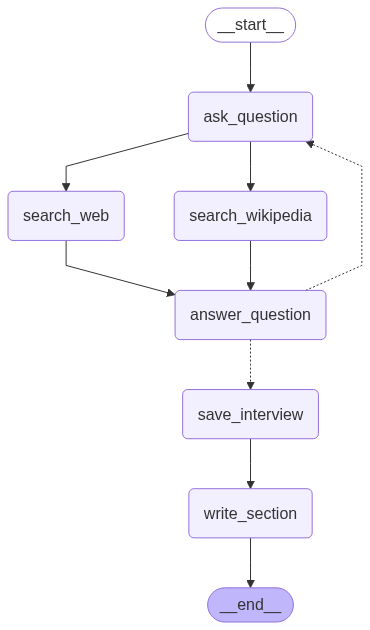

In [ ]:
from langchain_core.runnables import RunnableConfig


# Create graph
graph_builder = StateGraph(InterviewState)

# Add nodes
graph_builder.add_node("search_web", search_web)
graph_builder.add_node("search_wikipedia", search_wikipedia)
graph_builder.add_node("ask_question", generate_question)
graph_builder.add_node("answer_question", generate_answer)
graph_builder.add_node("save_interview", save_interview)
graph_builder.add_node("write_section", write_section)

# Connect nodes
graph_builder.add_edge(START, "ask_question")
graph_builder.add_edge("ask_question", "search_wikipedia")
graph_builder.add_edge("ask_question", "search_web")
graph_builder.add_edge("search_web", "answer_question")
graph_builder.add_edge("search_wikipedia", "answer_question")
graph_builder.add_conditional_edges(
    "answer_question",
    route_messages,
    {"ask_question": "ask_question", "save_interview": "save_interview"},
)
graph_builder.add_edge("save_interview", "write_section")
graph_builder.add_edge("write_section", END)

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
config = RunnableConfig(callbacks=[langfuse_handler], run_name="Conduct Interviews")
graph: CompiledStateGraph = graph_builder.compile(checkpointer=memory).with_config(config)

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# Pick one analyst
console.log(analysts[0])

[18:54:20] Analyst(                                                                                 ]8;id=800082;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_42530/3880302351.py\3880302351.py]8;;\:]8;id=465873;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_42530/3880302351.py#2\2]8;;\
               affiliation='University of Notre Dame',                                                             
               role='Theologian',                                                                                  
               name='Dr. Maria Rodriguez',                                                                         
               description='Dr. Rodriguez is a theologian with a focus on the historical                           
           development of Christian doctrine. She is well-versed in the writings of early Church                   
           Fathers and has a deep understanding of the apostolic tradition. Her analysis will                      
           provide insight into the traditional perspective on the benefits of Christianity,                       
           highlighting its role in shaping Western civilization and its continued influence on                    
           modern society.'                                                                                        
           )                                                                                                       

In [32]:
messages = [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}
input_values: dict[str, Any] = {
    "analyst": analysts[0],
    "messages": messages,
    "max_num_turns": 2,
}

interview = await graph.ainvoke(input_values, thread)

Markdown(interview["sections"][0])

ValueError: Structured Output response does not have a 'parsed' field nor a 'refusal' field. Received message:

content='' additional_kwargs={'parsed': None, 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 1406, 'total_tokens': 1407, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen/qwen3-30b-a3b', 'system_fingerprint': None, 'id': 'gen-1749322366-CpE53yKFun3iV5cAMaPy', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--be02c9f3-33b1-44b8-900c-1a77d1eca949-0' usage_metadata={'input_tokens': 1406, 'output_tokens': 1, 'total_tokens': 1407, 'input_token_details': {}, 'output_token_details': {}}

In [28]:
{
    "messages": [
        {
            "content": "Okay, let's get started.\n\nHi Dr. Reed,\n\nMy name is Maya Chen, and I'm conducting this analysis for [Insert Your Fictional Publication Name Here, e.g., The Analysis Herald]. Focusing on your expertise, one of our recurring areas is how religions, particularly Christianity given your focus, shape and are shaped by societal structures.\n\nFor this interview, my goal is to extract insights that are interesting – often highlighting surprising or non-obvious dynamics – and specific, grounded in concrete details from your academic knowledge and experience. Rather than general statements, I'm looking for observations you've noted in your research or teaching.\n\nTo begin, pulling from your area of specialization, what are a couple of the non-obvious benefits you've identified that Christianity offered to individuals and emerging societies?\n\nQuestion 1:\n\nUpon hearing that, I'm curious. Thinking specifically about the early Church's rise, you mentioned the appeal of bishops providing order. Could you elaborate further on the specific mechanisms or examples where these early *practical benefits* (like stability, structure) were layered onto existing societal or cultural frameworks?\n\nQuestion 2:\n\nAnd perhaps touching on conversion – isn't it frequently framed around the *content* of the message? But aren't there also powerfully non-content-based factors, like the visible stories or tangible actions reinforcing group cohesion? Can you shed light on a specific historical or cultural instance where such *social validation* through the narrative of conversion played a significant specific role in spreading Christianity?\n\nQuestion 3:\n\nFinally, looking at Christianity's broader societal impact, beyond immediate communities, you discussed it acting as a safety valve in a way. Are there concrete examples, perhaps from specific historical periods or manifestations you've studied, where this promise (of conflict resolution, divine mediation) *did* yield tangible social outcomes or reframed societal tensions in a predictable, beneficial manner from the perspective of *those involved*, even if it seems paradoxical by modern standards?\n\nLooking forward to refining my understanding further.\n\nThank you so much for your help!",
            "additional_kwargs": {"refusal": null},
            "response_metadata": {
                "token_usage": {
                    "completion_tokens": 724,
                    "prompt_tokens": 276,
                    "total_tokens": 1000,
                    "completion_tokens_details": null,
                    "prompt_tokens_details": null,
                },
                "model_name": "deepseek/deepseek-r1-0528-qwen3-8b",
                "system_fingerprint": null,
                "id": "gen-1749313339-FyyIcjUueWdDR6rYvXbA",
                "service_tier": null,
                "finish_reason": "stop",
                "logprobs": {"content": [], "refusal": []},
            },
            "type": "ai",
            "name": null,
            "id": "run--6839dd6c-aa4d-4e72-b32b-1b841b9b4b13-0",
            "example": false,
            "tool_calls": [],
            "invalid_tool_calls": [],
            "usage_metadata": {
                "input_tokens": 276,
                "output_tokens": 724,
                "total_tokens": 1000,
                "input_token_details": {},
                "output_token_details": {},
            },
        }
    ]
}

NameError: name 'null' is not defined

In [ ]:
{
    "messages": [
        {
            "content": "Okay, let's get started.\n\nHi Dr. Reed,\n\nMy name is Maya Chen, and I'm conducting this analysis for [Insert Your Fictional Publication Name Here, e.g., The Analysis Herald]. Focusing on your expertise, one of our recurring areas is how religions, particularly Christianity given your focus, shape and are shaped by societal structures.\n\nFor this interview, my goal is to extract insights that are interesting – often highlighting surprising or non-obvious dynamics – and specific, grounded in concrete details from your academic knowledge and experience. Rather than general statements, I'm looking for observations you've noted in your research or teaching.\n\nTo begin, pulling from your area of specialization, what are a couple of the non-obvious benefits you've identified that Christianity offered to individuals and emerging societies?\n\nQuestion 1:\n\nUpon hearing that, I'm curious. Thinking specifically about the early Church's rise, you mentioned the appeal of bishops providing order. Could you elaborate further on the specific mechanisms or examples where these early *practical benefits* (like stability, structure) were layered onto existing societal or cultural frameworks?\n\nQuestion 2:\n\nAnd perhaps touching on conversion – isn't it frequently framed around the *content* of the message? But aren't there also powerfully non-content-based factors, like the visible stories or tangible actions reinforcing group cohesion? Can you shed light on a specific historical or cultural instance where such *social validation* through the narrative of conversion played a significant specific role in spreading Christianity?\n\nQuestion 3:\n\nFinally, looking at Christianity's broader societal impact, beyond immediate communities, you discussed it acting as a safety valve in a way. Are there concrete examples, perhaps from specific historical periods or manifestations you've studied, where this promise (of conflict resolution, divine mediation) *did* yield tangible social outcomes or reframed societal tensions in a predictable, beneficial manner from the perspective of *those involved*, even if it seems paradoxical by modern standards?\n\nLooking forward to refining my understanding further.\n\nThank you so much for your help!",
            "additional_kwargs": {"refusal": null},
            "response_metadata": {
                "token_usage": {
                    "completion_tokens": 724,
                    "prompt_tokens": 276,
                    "total_tokens": 1000,
                    "completion_tokens_details": null,
                    "prompt_tokens_details": null,
                },
                "model_name": "deepseek/deepseek-r1-0528-qwen3-8b",
                "system_fingerprint": null,
                "id": "gen-1749313339-FyyIcjUueWdDR6rYvXbA",
                "service_tier": null,
                "finish_reason": "stop",
                "logprobs": {"content": [], "refusal": []},
            },
            "type": "ai",
            "name": null,
            "id": "run--6839dd6c-aa4d-4e72-b32b-1b841b9b4b13-0",
            "example": false,
            "tool_calls": [],
            "invalid_tool_calls": [],
            "usage_metadata": {
                "input_tokens": 276,
                "output_tokens": 724,
                "total_tokens": 1000,
                "input_token_details": {},
                "output_token_details": {},
            },
        }
    ]
}